In [1]:
import numpy as np
import constants
import quaternion as qt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def RK4(f, x0x1, y0, step, save_steps :int = 1, step_process = lambda y: y):
    # f MUST takes x and y as arguments: f(x, y)
    # It solves equation y' = f(x, y), y(x0) = y0 (everything is a vector)
    # from x0x1[0] to x0x1[1] on the grid with step step
    # save_steps - INT >= 1; integrator will save results every save_steps steps (2 - every second step, 1 - every step, etc.)
    # save_steps doesn't affect starting point and final point
    # step_process - FUNCTION that is called after every step to somehow process results (normalization and so on)
    # step_process - must take y argument (for single time step) as input and return the same shape numpy.ndarray
    # by default it doesn't do anything
    # returns array of (x, y) pairs
    if not isinstance(save_steps, int):
        raise TypeError("save_steps MUST be an integer")
    elif save_steps <= 0:
        raise ValueError("save_steps MUST be a natural number (1, 2, 3, ...)")
    
    x0 = x0x1[0]
    x1 = x0x1[1]
    current_x = np.array(x0, dtype = np.float64)
    current_y = np.array(y0, dtype = np.float64)
    result = [[x0, *y0]]
    h = step
    h2 = h/2
    h6 = h/6
    stop = x1 - h
    ind = 0
    while current_x < stop:
        ind += 1
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        if ind == save_steps:
            result.append(np.array([current_x.copy(), *current_y.copy()]))
            ind = 0

    if current_x < x1 - constants.max_to_zero:
        h = x1 - current_x
        h2 = h/2
        h6 = h/6
        k1 = np.array(f(current_x, current_y))
        k2 = np.array(f(current_x + h2, current_y + k1*h2))
        k3 = np.array(f(current_x + h2, current_y + k2*h2))
        k4 = np.array(f(current_x + h, current_y + k3*h))
        current_y += h6*(k1 + 2*k2 + 2*k3 + k4)
        current_y = step_process(current_y)
        current_x += h
        result.append(np.array([current_x.copy(), *current_y.copy()]))       
    
    return np.array(result)


class parameters:
    pass

J = np.zeros((3, 3))
J[0,0] = 1
J[1, 1] = 3
J[2, 2] = 2
Jinv = np.linalg.inv(J)

params = parameters()
params.J = J
params.Jinv = Jinv
params.grav_mu = constants.muE
params.a = 1
params.b = 2
params.S = params.a * params.b
params.rcmcp = [0.5, 1, 0.3] # radius vector from center of masses to the geometrical center
params.Cx = 1.05

# Цель - реализовать воздействие атмосферы
Модель атмосферы экспоненциальная:
$$
\rho(h)=\rho_0exp\big(-\frac{h-h_0}{b}\big)
$$
Где p<sub>0</sub> и b определяются из значений плотности атмосферы для двух значений высоты:
$$
\rho(0)=\rho_0=1.225\:\frac{kg}{m^3}\\
\rho(1000\;m)=1.11166\:\frac{kg}{m^3}\rightarrow b\approx10300\;m
$$
Атмосфера вращается с Землёй:
$$
\textbf{V}_{atm}=[\textbf{w}_{Earth},\;\textbf{r}_{sc}]\\
\:\\
where\\
\textbf{w}_{Earth}=
\begin{pmatrix}
0\\
0\\
\frac{2\pi}{24\;hours}
\end{pmatrix}_{ECI}=
\begin{pmatrix}
0\\
0\\
7.2722\cdot10^{-5}\frac{rad}{sec}
\end{pmatrix}_{ECEF}\\
$$
Сила, которую создаёт сопротивление атмосферы, приложена к центру пластины (КА считается тонкой пластиной) и равна
$$
\textbf{F}_{atm}=-\rho_{atm}\textbf{V}_{rel}\;|\textbf{V}_{rel}|\frac{C_x\;S}{2}\\
\textbf{V}_{rel}=\textbf{V}_{sc}-\textbf{V}_{atm}
$$
Момент, соответственно
$$
\textbf{M}_{atm}=[\textbf{r}_{cm-cp},\;\textbf{F}_{atm}]
$$

In [3]:
def p_atm(r):
    # r - radius vector. It could be in ECI as well as in ECEF, because only height matters
    # returns dendity of the atmosphere in kg/m^3
    p0 = 1.225
    b = 10300
    return p0 * np.exp(-(np.linalg.norm(r) - constants.RE)/b)

def V_atm(r):
    # r - radius vector. It could be in ECI as well as in ECEF
    # because in this model the atmosphere velocity is considered to be spherically symmetric
    # returns velocity of the atmosphere at the point with radius vector r
    # in system ECI/ECEF respectively to the r
    wE = np.array([0, 0, 7.2772e-5]) # rad/sec
    return np.cross(wE, r)

def AtmFroce(r, V, S, Cx, p = p_atm):
    # r and V - radius vector and speed of the space craft, must be in ECI, np.ndarray
    # S - area of the plate
    # Cx - drag coefficient
    # p - function of atmosphere density
    # returns drag froce of the atmosphere in ECI
    V_rel = V - V_atm(r)
    AtmFroce = -p_atm(r) * V_rel * np.linalg.norm(V_rel) * Cx * S / 2
    return AtmFroce

def AtmTorque(r, V, we, A, Ainv, S, Cx, r_cmcp, p = p_atm, Fatm = None):
    # r and V - radius vector and speed of the space craft, must be in ECI
    # we, A, Ainv are in bounded system; A and Ainv as quaternion!
    # S - area of the plate
    # Cx - drag coefficient
    # r_cmcp - radius vector from center of masses to the geometrical center of plate
    # in SPACECRAFT-BOUNDED system!!
    # p - function of atmosphere density
    # AtmFroce - drag force in ECI, np.ndarray
    # returns atmosphere's drag froce torque in ECEF
    
    # на будущее - подумать, как передать сюда AtmFroce, что бы не считать 2 раза
    if Fatm == None:
        Fatm = AtmFroce(r, V, S, Cx)
        
    F_bounded = (Ainv * np.quaternion(*Fatm) * A).vec
    M_atm = np.cross(r_cmcp, F_bounded)
    return M_atm

def GravTorque(t, r, V, we, A, Ainv, mu = constants.muE):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # we, A in bounded system; A as quaternion!
    # Conversion is supposed to be carried out in overlying function
    # returns gravitational torque IN BOUNDED basis
    rr = np.linalg.norm(r)
    e3 = r / rr # in ifr
    e3 = (Ainv * np.quaternion(*e3) * A).vec # convertion to bounded basis
    Me = 3 * mu / rr**3 * np.cross(e3, params.J @ e3)
    return Me


def Torque(t, r, V, we, A, params):
    # xe = ST * xi = A.inverse * xi * A
    # takes r, V in inertial reference system
    # w, A in bounded system as arrays
    # returns torque IN BOUNDED basis
    A = np.quaternion(*A)
    Ainv = A.inverse()
    M = np.zeros(3)
    M += GravTorque(t, r, V, we, A, Ainv)
    M += AtmTorque(r, V, we, A, Ainv, params.S, params.Cx, params.rcmcp)
    return M

def QuatDot(Ai, we):
    return np.quaternion(*Ai) * np.quaternion(*we) * 0.5

def Euler(t, r, V, we, A, params, M = lambda t, r, V, we, A: np.array([0, 0, 0])):
    # returns w' accroding to Euler's dinamic equation
    # A - orientation QUATERNION
    # M(t, w, A) - function of external moment in bounded axes
    return params.Jinv @ (M(t, r, V, we, A, params) - np.cross(we, params.J @ we))

def GravForce(t, r, mu = constants.muE):
    # Returns gravitational force in inertial system; m/s^2
    # r in INERTIAL; m
    return -mu * r / np.linalg.norm(r)**3

def f(t, x, params):
    # x[:3] - r, x[3:6] - V, x[6:9] - we, x[9:] - Ai
    r = x[:3]
    V = x[3:6]
    we = x[6:9]
    A = x[9:]
    
    res = np.empty(13)
    res[:3] = V
    
    atm = AtmFroce(r, V, params.S, params.Cx)    
    g = GravForce(t, r)
    
    res[3:6] = g + atm
    res[6:9] = Euler(t, r, V, we, A, params, Torque)
    res[9:] = QuatDot(A, we).components
    return res

def normalization(x):
    x[9:] /= np.linalg.norm(x[9:])
    return x

In [20]:
%%time
t0 = 0
t1 = 92*60
step = 0.1

# сделаю орбиту пониже (обычно я беру высоту МКС)
r0 = np.array([1, 0, 0]) * (constants.RE + constants.ISS_periapsis / 1.45)
# хочу круговую орбиту
V0 = np.array([0 , 1, 0]) * np.sqrt(params.grav_mu/np.linalg.norm(r0))
we0 = np.array([0.01, 0.01, 0.01])
A0 = np.quaternion(0.5, 0.5, 0.5, 0.5) # ОСК и ССК совпадают

x0 = np.hstack((r0, V0, we0, A0.components))

resultang = RK4(lambda t, x: f(t, x, params), (t0, t1), x0, step, step_process = normalization)

Wall time: 51.6 s


In [21]:
timepoints = resultang[:, 0]
r = resultang[:, 1:4]
V = resultang[:, 4:7]
we = resultang[:, 7:10]
A = resultang[:, 10:]

E3 = np.array([i / np.linalg.norm(i) for i in r])

E1 = np.array([(i - j * np.dot(i, j)) for i, j in zip(V, E3)])
for i in range(E1.shape[0]):
    E1[i] /= np.linalg.norm(E1[i])

E2 = np.array([np.cross(i, j) for i, j in zip(E3, E1)])

S1 = np.array([np.array([E1[i], E2[i], E3[i]]) for i in range(E1.shape[0])]) # матрицы перехода ИСК -> ОСК x' = Sx (НЕ линал)
S2 = np.array([qt.as_rotation_matrix(np.quaternion(*i)).T for i in A]) # матрицы перехода ИСК -> ССК x' = Sx (НЕ линал)
S3 = np.array([j @ i.T for i, j in zip(S1, S2)]) # матрицы перехода ОСК -> ССК x' = Sx (НЕ линал)
A3 = np.array([qt.from_rotation_matrix(i.T).components for i in S3]) # кватернионы поворота ОСК -> CCК

# Сделаю компоненты кватерниона более гладкими (а то у них знак скачет туда-сюда)
tol = 0.1
for i in range(1, A3.shape[0]):
    if np.linalg.norm(A3[i] - A3[i-1]) > tol:
        # Если сильно меняется норма - то произошёл "скачок"
        A3[i:] *= -1

In [22]:
wors = []
for i in range(E3.shape[0]):
    wors.append(E2[i] * np.dot(V[i], E1[i]) / np.linalg.norm(r[i]))

for i in range(len(wors)):
    wors[i] = S2[i] @ wors[i]

wors = np.array(wors)
wr = we - wors # в ССК

# Сам интеграл Якоби
J = []
for i in range(wr.shape[0]):
    J.append(0.5 * np.dot(wr[i], params.J @ wr[i]) + 
             np.linalg.norm(wors[i])**2 * 
             (1.5 * np.dot(S2[i] @ E3[i], params.J @ S2[i] @ E3[i]) - 0.5 * np.dot(S2[i] @ E2[i], params.J @ S2[i] @ E2[i])))
J = np.array(J)
print("Максимальное отклонение интеграла Якоби:", np.max(np.abs(J - J[0])))

Максимальное отклонение интеграла Якоби: 1.1897128241894144


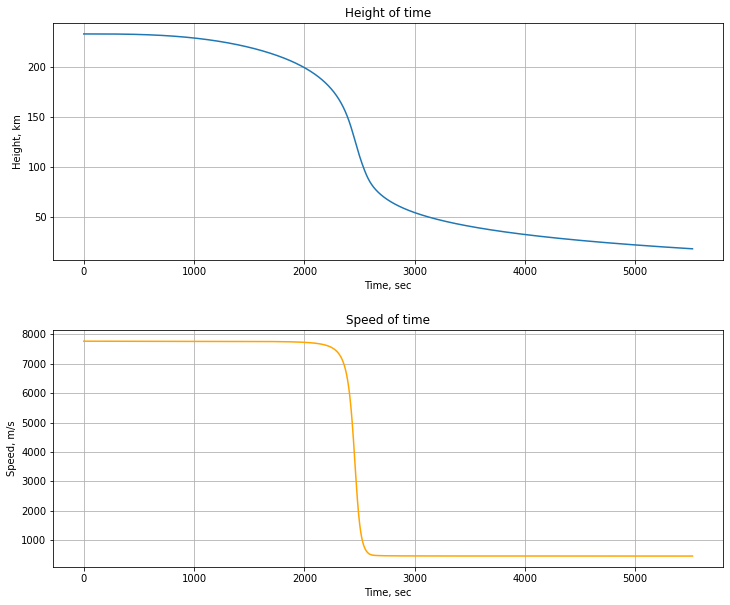

In [23]:
fig, axes = plt.subplots(2)

fig.set_figheight(10)
fig.set_figwidth(12)
fig.subplots_adjust(hspace = 0.3)

axes[0].plot(timepoints, (np.linalg.norm(r, axis = 1) - constants.RE)/1e3)
axes[0].set_xlabel("Time, sec")
axes[0].set_ylabel("Height, km")
axes[0].set_title("Height of time")
axes[0].grid(True)

axes[1].plot(timepoints, np.linalg.norm(V, axis = 1), color = "orange")
axes[1].set_xlabel("Time, sec")
axes[1].set_ylabel("Speed, m/s")
axes[1].set_title("Speed of time")
axes[1].grid(True)

Видно, что интеграл Якоби не сохраняется -> момент работает.  
Высота теряется, скорость падает -> лобовое сопротивление работает.